# I/O sequencing with `NidaqSequencer`

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qdlutils.hardware.nidaq.synchronous.nidaqsequencer import NidaqSequencer
from qdlutils.hardware.nidaq.synchronous.nidaqsequencerinput import *
from qdlutils.hardware.nidaq.synchronous.nidaqsequenceroutput import *

In [2]:
inputs = {
    'ai_voltage' : NidaqSequencerAIVoltage(
            name = 'ai_voltage',
            device = 'Dev1',
            channel = 'ai1',
    ),
    'ci_edge' : NidaqSequencerCIEdge(
            name = 'ci_edge',
            device = 'Dev1',
            channel = 'ctr2',
            terminal = 'PFI0',
    )
}

outputs = {
    'ao_voltage' : NidaqSequencerAOVoltage(
            name = 'ao_voltage',
            device = 'Dev1',
            channel = 'ao3',
            min_voltage = -3,
            max_voltage = 5
    ),
}

sequencer = NidaqSequencer(
        inputs= inputs,
        outputs=outputs,
        clock_device = 'Dev1',
        clock_channel = 'port0'
)

In [3]:
# Scan parameters
n_scans = 5

# Number of samples in the sequence
n_samples = 200

# Total sequence time in seconds
scan_time = 20

# Start and stop voltage of the sweep
start_voltage = 1
stop_voltage = 1.5

In [4]:
# Compute the remaining parameters and run the sequences

# Rate of samples per second
sample_rate = n_samples / scan_time
# Generate the data
voltages = np.linspace(start_voltage,stop_voltage, n_samples)
# Save in a dictionary to configure the sequencer
output_data = {'ao_voltage' : voltages}
# Input settings
input_samples = {
    'ai_voltage' : n_samples,
    'ci_edge': n_samples
}
readout_delays = {
    'ai_voltage' : 0,
    'ci_edge' : 0
}
soft_starts = {
    'ao_voltage' : True,
}

In [5]:
# Lists to save the data in
pd_voltages = []
counts = []
for i in range(n_scans):
    # Run the sequence
    sequencer.run_sequence(
        clock_rate = sample_rate,
        output_data = output_data,
        input_samples = input_samples,
        readout_delays = readout_delays,
        soft_start = soft_starts
    )
    # Save the results
    results = sequencer.get_data(inputs=True, outputs=False)
    pd_voltages.append( results['ai_voltage'] )
    counts.append( np.diff(results['ci_edge'], prepend=0) * sample_rate )

pd_voltages = np.array(pd_voltages)
counts = np.array(counts)

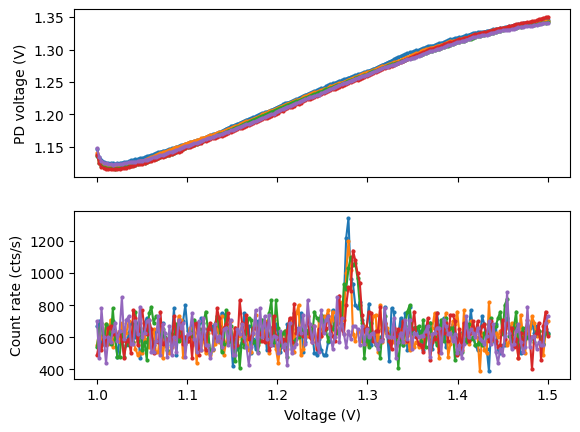

In [6]:
# Plot the results
fig, ax = plt.subplots(2,1, sharex=True)
for i in range(n_scans):
    ax[0].plot(voltages, pd_voltages[i], 'o-', markersize=2)
    ax[1].plot(voltages, counts[i], 'o-', markersize=2)
ax[1].set_xlabel('Voltage (V)')
ax[0].set_ylabel('PD voltage (V)')
ax[1].set_ylabel('Count rate (cts/s)')
plt.show()

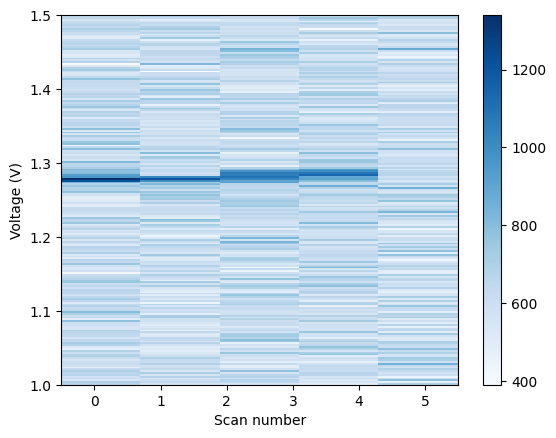

In [7]:
im = plt.imshow(
    counts.T, extent=[-0.5, n_scans+0.5, voltages[0], voltages[-1]], 
    origin='lower', interpolation='none', cmap='Blues', aspect='auto'
)
plt.colorbar(im)
plt.xlabel('Scan number')
plt.ylabel('Voltage (V)')
plt.show()